<img src=https://miro.medium.com/v2/resize:fit:640/format:webp/1*JcWSiiLzvNDQB7rIAgTYlg.jpeg>

Reference: https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030

# Mean Activation Logic is wrong, implement like in blog

In [ ]:
import torch
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
from torchvision.models import resnet18
import torch.nn.functional as F
import torchvision.transforms as transforms

import cv2
from PIL import Image
import matplotlib.pyplot as plt

Every layer in our neural network is a Module.

Every Module has a method called forward that calculates the output of the Module for a given input.

when you apply your network to an input image the first layer calculates its output, then the second, and so on. When we reach a layer for which we registered a hook, it not only calculates its output but also executes the hook.

So what is this good for? Let’s say we are interested in the feature maps of layer i. We register a forward hook on layer i that, once the forward method of layer i is called, saves the features of layer i in a variable.



## PyTorch Save Hook for Activations

In [ ]:
#Hook class to save features
class SaveFeatures:
  def __init__(self, layer):
    self.hook = layer.register_forward_hook(self.hook_fn)

  def hook_fn(self, module, input, output):
      self.features = output

  def close(self):
      self.hook.remove()

### Model - Freeze all layers

In [ ]:
def intialize_model():
  model = resnet18(pretrained = True).cuda().eval()
  for param in model.parameters():
      param.requires_grad = False

  return model

### Random Image

In [ ]:
def create_random_image(size):
    img = np.uint8(np.random.uniform(150,180, (size,size, 3))) / 255.0 #np.uint8 --> 0 to 255
    img = torch.tensor(img, dtype = torch.float32).permute(2,0,1).unsqueeze(0).cuda()
    img.requires_grad = True
    return img

In [ ]:
# Function to load your custom image instead of generating a random one
def load_custom_image(image_path, size):
    img = Image.open(image_path)  # Open image from path
    preprocess = transforms.Compose([
        transforms.Resize((size, size)),  # Resize to the desired size
        transforms.ToTensor(),  # Convert to tensor
    ])
    img = preprocess(img).unsqueeze(0).cuda()  # Add batch dimension and move to GPU
    img.requires_grad = True  # Set requires_grad to True to allow backprop
    return img

### Optimizer

In [ ]:
def backprop_image_with_mean_activations(model, img, activations, filter_idx, lr = 0.1, num_epochs = 20):

    optimizer = optim.Adam([img], lr = lr, weight_decay = 1e-6) # the param input should be an iterable type, so we convert it a list of one item
    mean_activations = []

    for _ in range(num_epochs):
        optimizer.zero_grad()
        output = model(img)
        mean_activation = activations.features[0, filter_idx].mean() #Get mean activation

        loss = -mean_activation # # Maximize filter activation

        mean_activations.append(mean_activation.item()) #Store it for plotting

        loss.backward()

        optimizer.step()

    return img, mean_activations

### Plot mean activations

In [ ]:
def plot_mean_activations(mean_activation):
   plt.plot(mean_activations)
   plt.title("Mean Activation Over Optimization Steps")
   plt.xlabel("Optimization Step or Epoch")
   plt.ylabel("Mean Activation")
   plt.show()

### Resize the image

when we start with a low resolution, we get a low-frequency pattern. After upscaling, the upscaled pattern has a lower frequency than what the optimizer would have generated if we had started at that larger image size with a random image. So when optimizing the pixel values in the next iteration we are at a better starting point and appear to avoid poor local minima.

In [ ]:
def upscale_image(img, new_size, blur_ksize = None):
    img = img.detach().cpu().numpy()[0].transpose(1,2,0) #C,H,W --> H,W,C
    img = np.clip(img, 0,1)
    img = cv2.resize(img, (new_size, new_size), interpolation = cv2.INTER_CUBIC)

    if blur_ksize is not None:
       img = cv2.blur(img, (blur_ksize, blur_ksize))

    img = torch.tensor(img, dtype = torch.float32).permute(2,0,1).unsqueeze(0).cuda()
    img.requires_grad = True  # Ensure gradient can be computed on the new image
    return img

### Save Image

In [ ]:
def save_image(img, layer, filter_idx):
    img = img.detach().cpu().numpy()[0].transpose(1,2,0) #access the first element of batch list where only one img exists
    img = np.clip(img, 0,1)
    filename = f"layer_{layer}_filter_{filter_idx}.jpg"
    plt.imsave(filename, img)
    return filename


### Cascading

In [ ]:
!wget https://live.staticflickr.com/8706/17038806044_478639f029_b.jpg -O hen.jpg

--2024-10-08 17:49:42--  https://live.staticflickr.com/8706/17038806044_478639f029_b.jpg
Resolving live.staticflickr.com (live.staticflickr.com)... 18.238.247.73, 2600:9000:2090:9200:0:5a51:64c9:c681, 2600:9000:2090:8800:0:5a51:64c9:c681, ...
Connecting to live.staticflickr.com (live.staticflickr.com)|18.238.247.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘hen.jpg’

hen.jpg                 [ <=>                ] 105.67K  --.-KB/s    in 0.008s  

2024-10-08 17:49:43 (12.1 MB/s) - ‘hen.jpg’ saved [108203]



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


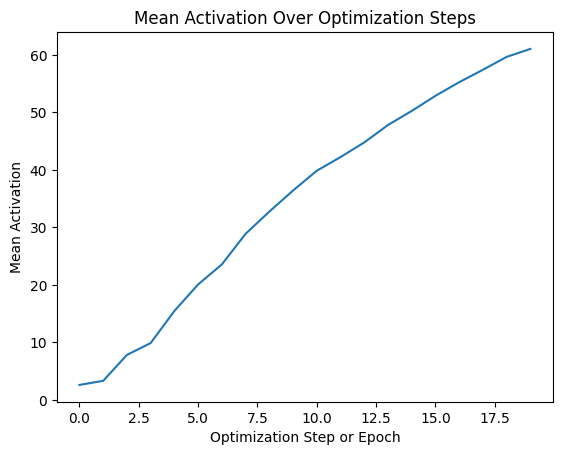

In [ ]:
resnet18_model = intialize_model()

# img = create_random_image(size = 224)
img = load_custom_image('hen.jpg', size=224)

layer_to_hook = 'layer4'

# layer_to_hook = 3 #VGG
# activations = SaveFeatures(list(resnet18_model.children())[0][layer_to_hook]) #VGG16

activations = SaveFeatures(getattr(resnet18_model, layer_to_hook))

img, mean_activations = backprop_image_with_mean_activations(resnet18_model, img, activations, filter_idx = 5)

plot_mean_activations(mean_activations)

img = upscale_image(img, new_size = 256, blur_ksize = 3)

saved_filename = save_image(img, layer_to_hook, filter_idx = 5)

activations.close()

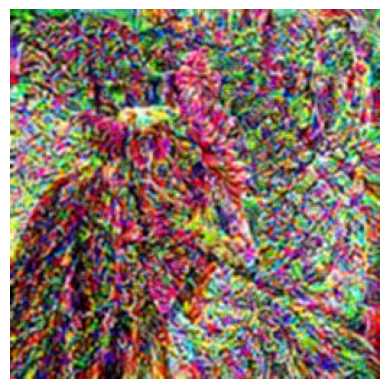

In [ ]:
saved_feature = plt.imread(saved_filename)
plt.imshow(saved_feature)
plt.axis('off')
plt.show()